# Processador de Dados de Vento - SODAR 100m

Este notebook processa os dados de velocidade do vento (WS) para extrair apenas os dados do sensor SODAR a 100m de altura e divide o dataset quando há gaps maiores que 4 horas (24 pontos de amostra).

## Fluxo de processamento:
1. Extrair colunas 'DT' e 'SODAR-100' do dataset WS.csv
2. Visualizar série temporal dos dados
3. Identificar gaps > 4 horas (24 pontos consecutivos NaN)
4. Dividir dataset em períodos válidos
5. Salvar datasets separados com nome baseado no período

#### 1. Importar bibliotecas necessárias

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurar matplotlib para melhor visualização
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

#### 2. Configurar caminhos e carregar dados

In [28]:
# Definir diretórios
csv_data_dir = Path("../converted_csv_data")
output_dir = Path("../filtered_csv_data")

# Criar diretório de saída se não existir
output_dir.mkdir(exist_ok=True)

# Caminho para o arquivo WS.csv
ws_file = csv_data_dir / "WS.csv"

if ws_file.exists():
    print(f"✓ Arquivo {ws_file.name} encontrado")
    
    # Carregar dados
    df_ws = pd.read_csv(ws_file)
    print(f"✓ Dados carregados: {df_ws.shape[0]} linhas × {df_ws.shape[1]} colunas")
    
    # Mostrar colunas disponíveis
    print(f"\nColunas disponíveis:")
    print(df_ws.columns.tolist())
else:
    print(f"✗ Arquivo {ws_file.name} não encontrado")

✓ Arquivo WS.csv encontrado
✓ Dados carregados: 41786 linhas × 27 colunas

Colunas disponíveis:
['DT', 'SODAR-30', 'SODAR-40', 'SODAR-50', 'SODAR-60', 'SODAR-70', 'SODAR-80', 'SODAR-90', 'SODAR-100', 'SODAR-110', 'SODAR-120', 'SODAR-130', 'SODAR-140', 'SODAR-150', 'SODAR-160', 'SODAR-170', 'SODAR-180', 'SODAR-190', 'SODAR-200', 'SODAR-210', 'SODAR-220', 'SODAR-230', 'SODAR-240', 'SODAR-250', 'SODAR-260', 'SODAR-270', 'SODAR-280']


#### 3. Extrair dados SODAR-100 e criar dataset WS100

In [29]:
# Verificar se a coluna SODAR-100 existe
if 'SODAR-100' in df_ws.columns:
    # Extrair apenas as colunas necessárias
    ws100 = df_ws[['DT', 'SODAR-100']].copy()
    
    # Converter coluna DT para datetime
    ws100['DT'] = pd.to_datetime(ws100['DT'])
    
    # Definir DT como índice
    ws100.set_index('DT', inplace=True)
    
    print(f"✓ Dataset WS100 criado com {ws100.shape[0]} registros")
    print(f"✓ Período: {ws100.index.min()} até {ws100.index.max()}")
    print(f"✓ Valores NaN: {ws100['SODAR-100'].isna().sum()} ({ws100['SODAR-100'].isna().sum()/len(ws100)*100:.1f}%)")
    
    # Salvar WS100 inicial
    ws100_path = output_dir / "WS100.csv"
    ws100.to_csv(ws100_path)
    print(f"✓ WS100.csv salvo em {ws100_path}")
    
    # Mostrar estatísticas básicas
    print(f"\n=== Estatísticas WS100 ===")
    print(ws100['SODAR-100'].describe())
    
else:
    print("✗ Coluna 'SODAR-100' não encontrada no dataset")
    print("Colunas que contêm '100':")
    cols_100 = [col for col in df_ws.columns if '100' in str(col)]
    print(cols_100)

✓ Dataset WS100 criado com 41786 registros
✓ Período: 2021-11-10 17:20:00 até 2022-10-09 08:30:00
✓ Valores NaN: 712 (1.7%)
✓ WS100.csv salvo em ../filtered_csv_data/WS100.csv

=== Estatísticas WS100 ===
count    41074.000000
mean         7.301744
std          2.577171
min          0.070000
25%          5.550000
50%          7.380000
75%          9.150000
max         32.490000
Name: SODAR-100, dtype: float64


#### 4. Visualizar série temporal dos dados SODAR-100

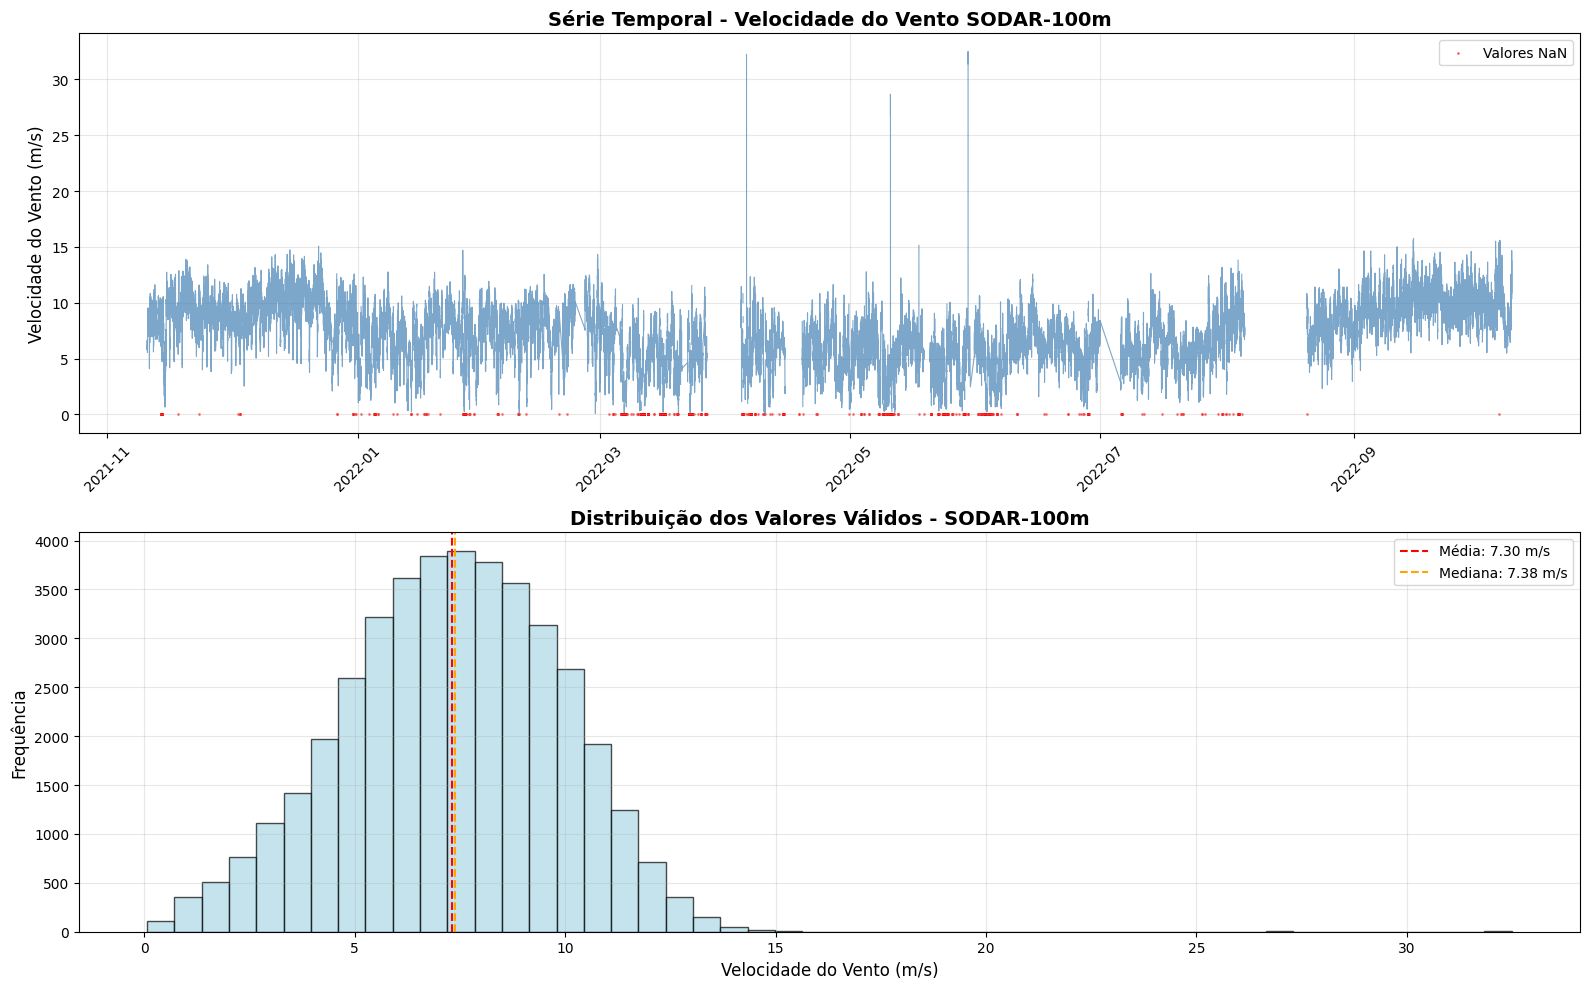


=== Informações da Série Temporal ===
Total de registros: 41786
Valores válidos: 41074 (98.3%)
Valores NaN: 712 (1.7%)
Período total: 332 dias


In [30]:
# Criar visualização da série temporal
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Gráfico 1: Série temporal completa
ax1.plot(ws100.index, ws100['SODAR-100'], linewidth=0.8, alpha=0.7, color='steelblue')
ax1.set_title('Série Temporal - Velocidade do Vento SODAR-100m', fontsize=14, fontweight='bold')
ax1.set_ylabel('Velocidade do Vento (m/s)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Adicionar linha para valores NaN
nan_mask = ws100['SODAR-100'].isna()
if nan_mask.any():
    ax1.scatter(ws100.index[nan_mask], [0]*nan_mask.sum(), 
               color='red', alpha=0.5, s=1, label='Valores NaN')
    ax1.legend()

# Gráfico 2: Histograma dos valores válidos
valid_data = ws100['SODAR-100'].dropna()
ax2.hist(valid_data, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
ax2.set_title('Distribuição dos Valores Válidos - SODAR-100m', fontsize=14, fontweight='bold')
ax2.set_xlabel('Velocidade do Vento (m/s)', fontsize=12)
ax2.set_ylabel('Frequência', fontsize=12)
ax2.grid(True, alpha=0.3)

# Adicionar estatísticas no histograma
ax2.axvline(valid_data.mean(), color='red', linestyle='--', 
           label=f'Média: {valid_data.mean():.2f} m/s')
ax2.axvline(valid_data.median(), color='orange', linestyle='--', 
           label=f'Mediana: {valid_data.median():.2f} m/s')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n=== Informações da Série Temporal ===")
print(f"Total de registros: {len(ws100)}")
print(f"Valores válidos: {len(valid_data)} ({len(valid_data)/len(ws100)*100:.1f}%)")
print(f"Valores NaN: {nan_mask.sum()} ({nan_mask.sum()/len(ws100)*100:.1f}%)")
print(f"Período total: {(ws100.index.max() - ws100.index.min()).days} dias")

#### 5. Identificar gaps maiores que 4 horas (24 pontos consecutivos)

In [31]:
def find_large_gaps(series, max_gap_size=24, max_time_gap_hours=4):
    """
    Identifica gaps maiores que max_gap_size pontos consecutivos de NaN
    OU gaps temporais maiores que max_time_gap_hours horas entre timestamps
    
    Args:
        series: Série pandas com valores NaN e índice datetime
        max_gap_size: Tamanho máximo do gap em pontos consecutivos (24 = 4 horas para dados de 10 min)
        max_time_gap_hours: Máximo gap temporal em horas entre timestamps consecutivos
    
    Returns:
        Lista de tuplas (início, fim, tipo_gap) dos gaps grandes
    """
    large_gaps = []
    
    # 1. Identificar gaps de valores NaN consecutivos
    is_nan = series.isna()
    nan_diff = is_nan.astype(int).diff().fillna(0)
    
    gap_starts = series.index[nan_diff == 1].tolist()
    gap_ends = series.index[nan_diff == -1].tolist()
    
    # Ajustar se a série começar ou terminar com NaN
    if is_nan.iloc[0]:
        gap_starts.insert(0, series.index[0])
    if is_nan.iloc[-1]:
        gap_ends.append(series.index[-1])
    
    # Encontrar gaps de NaN grandes
    for start, end in zip(gap_starts, gap_ends):
        gap_length = len(series.loc[start:end])
        if gap_length > max_gap_size:
            large_gaps.append((start, end, gap_length, 'NaN_gap'))
    
    # 2. Identificar gaps temporais (diferença entre timestamps > max_time_gap_hours)
    time_diffs = series.index.to_series().diff()
    max_time_gap = pd.Timedelta(hours=max_time_gap_hours)
    
    # Encontrar onde a diferença temporal é maior que o limite
    time_gap_mask = time_diffs > max_time_gap
    time_gap_indices = series.index[time_gap_mask]
    
    for gap_end in time_gap_indices:
        # Encontrar o índice anterior
        gap_end_pos = series.index.get_loc(gap_end)
        if gap_end_pos > 0:
            gap_start = series.index[gap_end_pos - 1]
            time_diff_hours = (gap_end - gap_start).total_seconds() / 3600
            large_gaps.append((gap_start, gap_end, time_diff_hours, 'time_gap'))
    
    # Ordenar gaps por timestamp de início
    large_gaps.sort(key=lambda x: x[0])
    
    return large_gaps

# Encontrar gaps maiores que 4 horas (24 pontos) OU gaps temporais > 4 horas
large_gaps = find_large_gaps(ws100['SODAR-100'], max_gap_size=24, max_time_gap_hours=4)

print(f"=== Análise de Gaps Grandes (> 4 horas) ===")
print(f"Gaps encontrados: {len(large_gaps)}")

if large_gaps:
    print(f"\nDetalhes dos gaps:")
    for i, gap_info in enumerate(large_gaps, 1):
        start, end, size, gap_type = gap_info
        
        if gap_type == 'NaN_gap':
            duration_hours = size * 10 / 60  # 10 min por ponto
            print(f"  Gap {i} (NaN): {start} até {end}")
            print(f"             Duração: {size} pontos ({duration_hours:.1f} horas)")
        elif gap_type == 'time_gap':
            print(f"  Gap {i} (Temporal): {start} até {end}")
            print(f"                   Duração: {size:.1f} horas")
else:
    print("Nenhum gap maior que 4 horas encontrado!")
    
# Mostrar estatísticas dos gaps temporais
time_diffs = ws100.index.to_series().diff()
print(f"\n=== Estatísticas de Intervalos Temporais ===")
print(f"Intervalo mínimo: {time_diffs.min()}")
print(f"Intervalo máximo: {time_diffs.max()}")
print(f"Intervalo médio: {time_diffs.mean()}")
print(f"Intervalos > 4h: {(time_diffs > pd.Timedelta(hours=4)).sum()}")

=== Análise de Gaps Grandes (> 4 horas) ===
Gaps encontrados: 21

Detalhes dos gaps:
  Gap 1 (Temporal): 2021-11-13 03:40:00 até 2021-11-13 08:10:00
                   Duração: 4.5 horas
  Gap 2 (Temporal): 2021-12-02 20:50:00 até 2021-12-03 01:10:00
                   Duração: 4.3 horas
  Gap 3 (Temporal): 2022-01-21 04:50:00 até 2022-01-21 12:00:00
                   Duração: 7.2 horas
  Gap 4 (Temporal): 2022-02-19 03:20:00 até 2022-02-20 00:10:00
                   Duração: 20.8 horas
  Gap 5 (Temporal): 2022-02-23 00:30:00 até 2022-02-25 10:40:00
                   Duração: 58.2 horas
  Gap 6 (Temporal): 2022-03-05 00:20:00 até 2022-03-06 00:10:00
                   Duração: 23.8 horas
  Gap 7 (Temporal): 2022-03-08 13:50:00 até 2022-03-09 00:10:00
                   Duração: 10.3 horas
  Gap 8 (NaN): 2022-03-11 18:00:00 até 2022-03-11 22:30:00
             Duração: 28 pontos (4.7 horas)
  Gap 9 (Temporal): 2022-03-15 10:00:00 até 2022-03-15 15:20:00
                   Duração: 5.

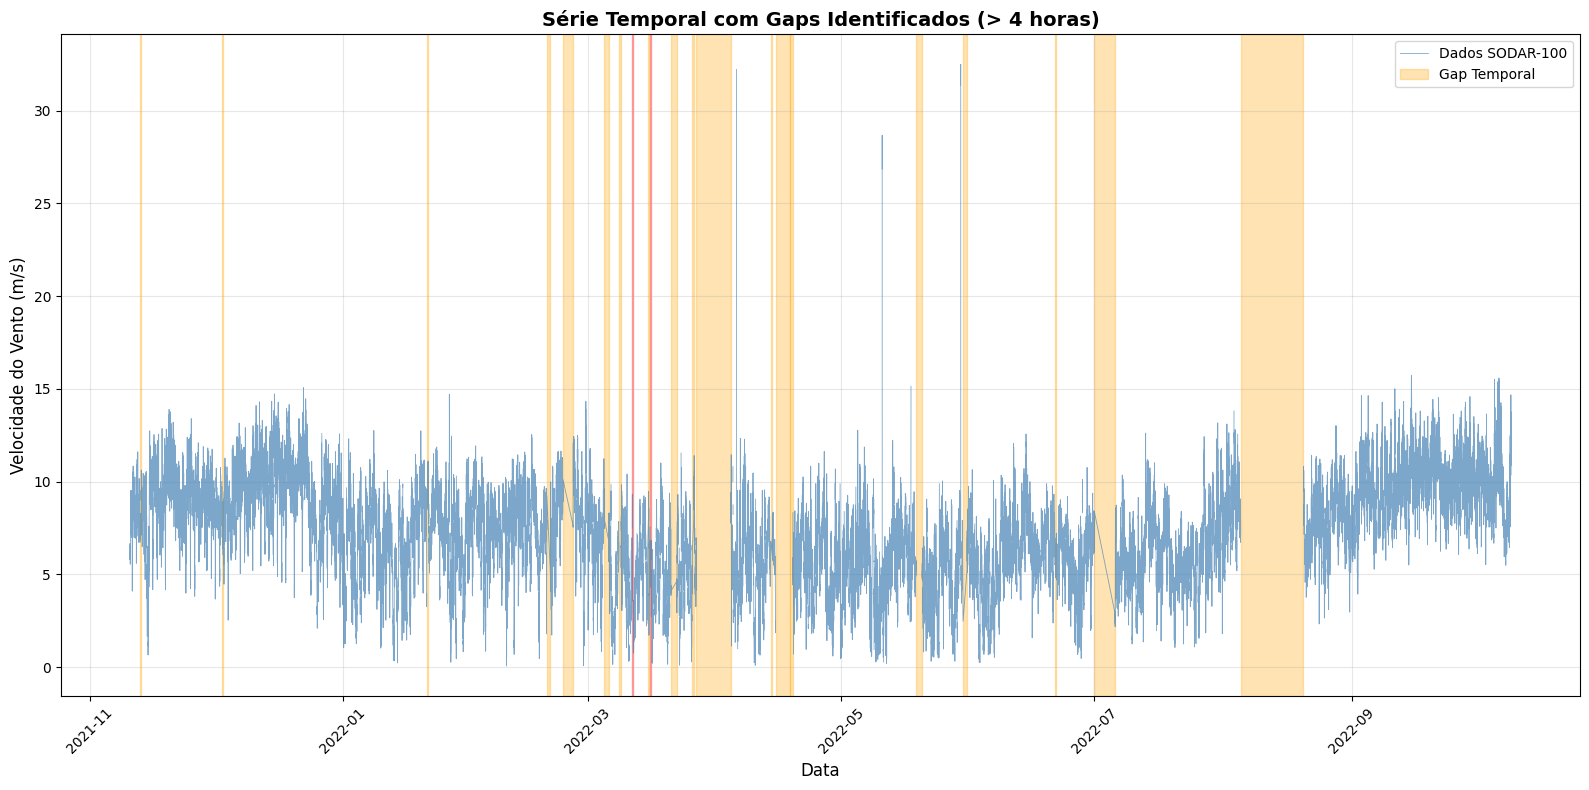


=== Resumo dos Gaps Encontrados ===
 Gap     Tipo           Início              Fim          Duração
   1 Time Gap 2021-11-13 03:40 2021-11-13 08:10        4.5 horas
   2 Time Gap 2021-12-02 20:50 2021-12-03 01:10        4.3 horas
   3 Time Gap 2022-01-21 04:50 2022-01-21 12:00        7.2 horas
   4 Time Gap 2022-02-19 03:20 2022-02-20 00:10       20.8 horas
   5 Time Gap 2022-02-23 00:30 2022-02-25 10:40       58.2 horas
   6 Time Gap 2022-03-05 00:20 2022-03-06 00:10       23.8 horas
   7 Time Gap 2022-03-08 13:50 2022-03-09 00:10       10.3 horas
   8  Nan Gap 2022-03-11 18:00 2022-03-11 22:30 28 pontos (4.7h)
   9 Time Gap 2022-03-15 10:00 2022-03-15 15:20        5.3 horas
  10  Nan Gap 2022-03-15 23:50 2022-03-16 06:10 39 pontos (6.5h)
  11 Time Gap 2022-03-21 01:20 2022-03-22 10:40       33.3 horas
  12 Time Gap 2022-03-26 04:30 2022-03-26 12:40        8.2 horas
  13 Time Gap 2022-03-27 03:50 2022-04-04 11:00      199.2 horas
  14 Time Gap 2022-04-14 01:40 2022-04-14 10:50      

In [32]:
# Visualizar gaps encontrados na série temporal
if large_gaps:
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    # Plotar série temporal
    ax.plot(ws100.index, ws100['SODAR-100'], linewidth=0.6, alpha=0.7, color='steelblue', label='Dados SODAR-100')
    
    # Marcar gaps de diferentes tipos
    for i, gap_info in enumerate(large_gaps):
        start, end, size, gap_type = gap_info
        
        if gap_type == 'NaN_gap':
            ax.axvspan(start, end, alpha=0.3, color='red', label='Gap NaN' if i == 0 else "")
        elif gap_type == 'time_gap':
            ax.axvspan(start, end, alpha=0.3, color='orange', label='Gap Temporal' if i == 0 else "")
    
    ax.set_title('Série Temporal com Gaps Identificados (> 4 horas)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Velocidade do Vento (m/s)', fontsize=12)
    ax.set_xlabel('Data', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Criar tabela resumo dos gaps
    gap_summary = []
    for i, gap_info in enumerate(large_gaps, 1):
        start, end, size, gap_type = gap_info
        if gap_type == 'NaN_gap':
            duration_str = f"{size} pontos ({size * 10 / 60:.1f}h)"
        else:
            duration_str = f"{size:.1f} horas"
        
        gap_summary.append({
            'Gap': i,
            'Tipo': gap_type.replace('_', ' ').title(),
            'Início': start.strftime('%Y-%m-%d %H:%M'),
            'Fim': end.strftime('%Y-%m-%d %H:%M'),
            'Duração': duration_str
        })
    
    gap_df = pd.DataFrame(gap_summary)
    print(f"\n=== Resumo dos Gaps Encontrados ===")
    print(gap_df.to_string(index=False))
    
else:
    print("✓ Nenhum gap encontrado - série temporal contínua")

#### 6. Dividir dataset em períodos válidos

In [33]:
def split_dataset_by_gaps(df, large_gaps):
    """
    Divide o dataset em períodos válidos baseado nos gaps grandes (NaN ou temporais)
    
    Args:
        df: DataFrame com índice datetime
        large_gaps: Lista de tuplas (início, fim, tamanho, tipo) dos gaps
    
    Returns:
        Lista de DataFrames divididos
    """
    if not large_gaps:
        return [df]  # Retorna dataset original se não há gaps grandes
    
    datasets = []
    start_idx = df.index[0]
    
    for gap_info in large_gaps:
        gap_start, gap_end, size, gap_type = gap_info
        
        if gap_type == 'NaN_gap':
            # Para gaps de NaN, dividir antes do início do gap
            end_idx = gap_start
            if start_idx < end_idx:
                period_df = df.loc[start_idx:end_idx].copy()
                # Remover últimas linhas NaN se existirem
                period_df = period_df.dropna().copy()
                if len(period_df) > 0:
                    datasets.append(period_df)
            
            # Próximo período começa após o gap
            start_idx = gap_end
            
        elif gap_type == 'time_gap':
            # Para gaps temporais, dividir exatamente no gap
            end_idx = gap_start
            if start_idx <= end_idx:
                period_df = df.loc[start_idx:end_idx].copy()
                # Manter dados válidos (incluindo o ponto antes do gap)
                period_df = period_df.dropna().copy()
                if len(period_df) > 0:
                    datasets.append(period_df)
            
            # Próximo período começa após o gap temporal
            start_idx = gap_end
    
    # Adicionar período final após o último gap
    if start_idx <= df.index[-1]:
        final_period = df.loc[start_idx:].copy()
        final_period = final_period.dropna().copy()
        if len(final_period) > 0:
            datasets.append(final_period)
    
    return datasets

# Dividir dataset considerando gaps de NaN e gaps temporais
split_datasets = split_dataset_by_gaps(ws100, large_gaps)

print(f"=== Divisão do Dataset ===")
print(f"Datasets criados: {len(split_datasets)}")

# Mostrar informações de cada dataset
for i, dataset in enumerate(split_datasets, 1):
    start_date = dataset.index[0]
    end_date = dataset.index[-1]
    duration_days = (end_date - start_date).days
    duration_hours = (end_date - start_date).total_seconds() / 3600
    
    # Verificar continuidade temporal
    time_diffs = dataset.index.to_series().diff()
    max_interval = time_diffs.max()
    gaps_4h = (time_diffs > pd.Timedelta(hours=4)).sum()
    
    print(f"\nDataset {i}:")
    print(f"  Período: {start_date.strftime('%Y-%m-%d %H:%M')} até {end_date.strftime('%Y-%m-%d %H:%M')}")
    print(f"  Duração: {duration_days} dias ({duration_hours:.1f} horas)")
    print(f"  Registros: {len(dataset)}")
    print(f"  Valores válidos: {dataset['SODAR-100'].notna().sum()} ({dataset['SODAR-100'].notna().sum()/len(dataset)*100:.1f}%)")
    print(f"  Máximo intervalo: {max_interval}")
    print(f"  Gaps > 4h internos: {gaps_4h}")

=== Divisão do Dataset ===
Datasets criados: 22

Dataset 1:
  Período: 2021-11-10 17:20 até 2021-11-13 03:40
  Duração: 2 dias (58.3 horas)
  Registros: 351
  Valores válidos: 351 (100.0%)
  Máximo intervalo: 0 days 00:10:00
  Gaps > 4h internos: 0

Dataset 2:
  Período: 2021-11-13 08:10 até 2021-12-02 20:40
  Duração: 19 dias (468.5 horas)
  Registros: 2787
  Valores válidos: 2787 (100.0%)
  Máximo intervalo: 0 days 01:20:00
  Gaps > 4h internos: 0

Dataset 3:
  Período: 2021-12-03 01:10 até 2022-01-21 04:40
  Duração: 49 dias (1179.5 horas)
  Registros: 7039
  Valores válidos: 7039 (100.0%)
  Máximo intervalo: 0 days 01:00:00
  Gaps > 4h internos: 0

Dataset 4:
  Período: 2022-01-21 12:00 até 2022-02-19 03:20
  Duração: 28 dias (687.3 horas)
  Registros: 4084
  Valores válidos: 4084 (100.0%)
  Máximo intervalo: 0 days 03:00:00
  Gaps > 4h internos: 0

Dataset 5:
  Período: 2022-02-20 00:10 até 2022-02-23 00:30
  Duração: 3 dias (72.3 horas)
  Registros: 433
  Valores válidos: 433 (10

#### 7. Salvar datasets divididos com nomes baseados no período

In [34]:
def generate_period_filename(start_date, end_date):
    """
    Gera nome do arquivo baseado no período dos dados
    
    Args:
        start_date: Data inicial
        end_date: Data final
    
    Returns:
        String com nome do arquivo
    """
    start_str = start_date.strftime('%Y%m%d')
    end_str = end_date.strftime('%Y%m%d')
    
    if start_str == end_str:
        return f"WS100_{start_str}.csv"
    else:
        return f"WS100_{start_str}_to_{end_str}.csv"

# Salvar cada dataset dividido
saved_files = []

print(f"=== Salvando Datasets Divididos ===")

if len(split_datasets) == 1:
    # Se não há gaps grandes, salvar como WS100_complete.csv
    filename = "WS100_complete.csv"
    filepath = output_dir / filename
    split_datasets[0].to_csv(filepath)
    saved_files.append(filepath)
    print(f"✓ {filename} salvo ({len(split_datasets[0])} registros)")
else:
    # Salvar múltiplos datasets
    for i, dataset in enumerate(split_datasets, 1):
        start_date = dataset.index[0]
        end_date = dataset.index[-1]
        
        filename = generate_period_filename(start_date, end_date)
        filepath = output_dir / filename
        
        dataset.to_csv(filepath)
        saved_files.append(filepath)
        
        print(f"✓ {filename} salvo ({len(dataset)} registros)")
        print(f"  └── Período: {start_date.strftime('%Y-%m-%d %H:%M')} até {end_date.strftime('%Y-%m-%d %H:%M')}")

print(f"\n=== Resumo Final ===")
print(f"Total de arquivos salvos: {len(saved_files)}")
print(f"Diretório de saída: {output_dir}")
print(f"\nArquivos criados:")
for filepath in saved_files:
    file_size = filepath.stat().st_size
    print(f"  - {filepath.name} ({file_size:,} bytes)")

=== Salvando Datasets Divididos ===
✓ WS100_20211110_to_20211113.csv salvo (351 registros)
  └── Período: 2021-11-10 17:20 até 2021-11-13 03:40
✓ WS100_20211113_to_20211202.csv salvo (2787 registros)
  └── Período: 2021-11-13 08:10 até 2021-12-02 20:40
✓ WS100_20211203_to_20220121.csv salvo (7039 registros)
  └── Período: 2021-12-03 01:10 até 2022-01-21 04:40
✓ WS100_20220121_to_20220219.csv salvo (4084 registros)
  └── Período: 2022-01-21 12:00 até 2022-02-19 03:20
✓ WS100_20220220_to_20220223.csv salvo (433 registros)
  └── Período: 2022-02-20 00:10 até 2022-02-23 00:30
✓ WS100_20220225_to_20220305.csv salvo (1086 registros)
  └── Período: 2022-02-25 10:40 até 2022-03-05 00:20
✓ WS100_20220306_to_20220308.csv salvo (311 registros)
  └── Período: 2022-03-06 00:10 até 2022-03-08 11:40
✓ WS100_20220309_to_20220311.csv salvo (364 registros)
  └── Período: 2022-03-09 00:10 até 2022-03-11 17:50
✓ WS100_20220311_to_20220315.csv salvo (486 registros)
  └── Período: 2022-03-11 22:30 até 2022-

#### 8. Visualização final dos datasets divididos

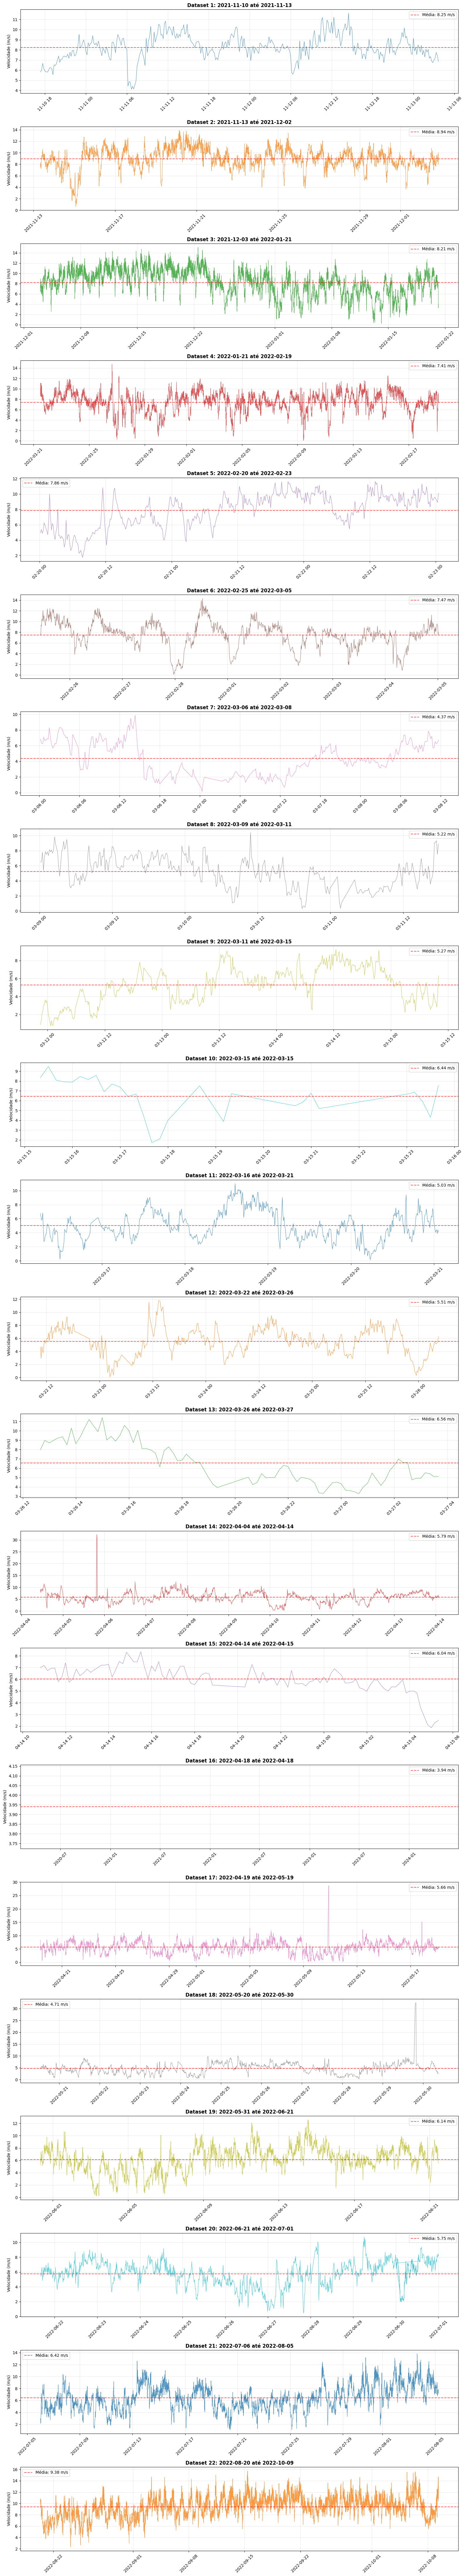


🎉 Processamento concluído com sucesso!
✓ Dados SODAR-100m extraídos e processados
✓ 21 gaps grandes identificados
✓ 22 datasets criados
✓ Arquivos salvos em: ../filtered_csv_data


In [35]:
# Criar visualização dos datasets divididos
if len(split_datasets) > 1:
    fig, axes = plt.subplots(len(split_datasets), 1, figsize=(16, 4*len(split_datasets)))
    
    if len(split_datasets) == 1:
        axes = [axes]
    
    for i, (dataset, ax) in enumerate(zip(split_datasets, axes), 1):
        ax.plot(dataset.index, dataset['SODAR-100'], linewidth=0.8, 
               color=f'C{i-1}', alpha=0.8)
        
        ax.set_title(f'Dataset {i}: {dataset.index[0].strftime("%Y-%m-%d")} até {dataset.index[-1].strftime("%Y-%m-%d")}', 
                    fontsize=12, fontweight='bold')
        ax.set_ylabel('Velocidade (m/s)', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Adicionar estatísticas
        mean_val = dataset['SODAR-100'].mean()
        ax.axhline(mean_val, color='red', linestyle='--', alpha=0.7, 
                  label=f'Média: {mean_val:.2f} m/s')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ Dataset único - visualização já mostrada anteriormente")

print(f"\n🎉 Processamento concluído com sucesso!")
print(f"✓ Dados SODAR-100m extraídos e processados")
print(f"✓ {len(large_gaps)} gaps grandes identificados")
print(f"✓ {len(split_datasets)} datasets criados")
print(f"✓ Arquivos salvos em: {output_dir}")